In [358]:
#Multi-view method for detecting deviating behaviors of the control valve system and providing additional information such as the reason and suitable action
#for the detected deviating behaviors

In [359]:
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import requests
import json
import os
import sys
import math

import random as rand

from matplotlib import dates
from datetime import datetime, date, time
from influxdb import DataFrameClient
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial import distance
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.legend import Legend
%matplotlib inline

heating_threshold = 10

colors = ['lightcoral','red', 'darkred', 'lightskyblue', 'blue', 'darkblue', 'lightgreen','green', 'darkgreen', 'violet', 'm', 'purple']
colors2 = ['red', 'blue', 'green', 'violet', 'purple', 'black', 'orange']

all_month = ['January', 'February', 'March', 'April', 'May', 'June', 'july', 'August', 'September', 'October', 'November', 'December']

In [360]:
def train_test(dataset, random_state_var=None):
    heating_month = set(dataset.index.month)
    
    df_training_set = pd.DataFrame()
    df_testing_set = pd.DataFrame()
    
    df_dataset = pd.DataFrame()
    
    for month in heating_month:
        df_temp = pd.DataFrame()
        
        df_temp = dataset.loc[dataset.index.month == month]
        
        #Sampling data to training (%70) and testing set (%30)
        df_training_set = df_temp.sample(frac=0.7, random_state=random_state_var)
        df_testing_set = df_temp.drop(df_training_set.index)
        
        #Setting is_train to 1 because it is training set
        df_training_set['is_train'] = 1
        df_training_set['is_outlier'] = 0

        #Setting is_train to 0 because it is testing set
        df_testing_set['is_train'] = 0
        df_testing_set['is_outlier'] = 0

        df_dataset = df_dataset.append(df_training_set)
        df_dataset = df_dataset.append(df_testing_set)
        

    df_dataset = df_dataset.sort_index()

    return df_dataset

In [361]:
#normalize data
def norm(data_frame_arg, data_frame_stats):
    return ( data_frame_arg - data_frame_stats['mean']) / data_frame_stats['std']
    

#hampel filter
def hampel(vals_orig, W=7, t0=3):

    '''

    vals: pandas series of values from which to remove outliers

    W: size of window (including the sample; 7 is equal to 3 on either side of value)

    '''

    #Make copy so original not edited

    vals=vals_orig.copy() 
    
    #Hampel Filter

    L= 1.4826

    rolling_median=vals.rolling(W).median()

    difference=np.abs(rolling_median-vals)

    median_abs_deviation=difference.rolling(W).median()

    threshold= t0 * L * median_abs_deviation

    outlier_idx=difference>threshold

    vals[outlier_idx]=rolling_median #replace it with np.nan or 99999 

    return(vals)

In [362]:
#Creating a function that takes a dataset (test data) and return the dates with deviating behaviors
def deviating_behavior_detector(test_data, model):
    
    df_test_data = test_data.copy()
    
    
    multiview_model_temp = model.copy()
    multiview_model_temp['is_typical'] = 1
    
    unseen_operating_mode = pd.DataFrame()
    
    results = pd.DataFrame(columns=['date', 'day', 'avg. outdoor temp', 'type of outlier', 'reason', 'action'])

    for index, row in test_data.iterrows():
        
        reason = []
        is_outlier = 0
        is_unseen = 0

        #Store the results from euclidean distance measure
        #Finding the distance between new daily data and the model's operating behavior modes
        #The features in vector 1 are secondary supply temperature, secondary return temperautre, primary delta, and outdoor temperature
        operating_modes_similarity = []
        
        
        vom_similarity = []
        efficiency_similarity = []
        ot_similarity = []
        
        
        #The average daily values will be stored in this list
        #Vector 1 will store sec_supply_temp, sec_return_temp, prim_delta, and outdoor_temp
        new_daily_data = [row['sec_supply_temp'], row['sec_return_temp'], row['prim_heat_load'], row['d_avg_outdoor_temp']]

        for cluster in clusters:

            model_operating_modes_values = [multiview_model_temp.iloc[cluster]['sec_supply_temp'], 
                                            multiview_model_temp.iloc[cluster]['sec_return_temp'], 
                                            multiview_model_temp.iloc[cluster]['prim_heat_load'], 
                                            multiview_model_temp.iloc[cluster]['outdoor_temp']]


            #idea: calculate euclidean distance to VOM and efficiency and compare with their std.
            #if the distance is greater thatn the std of them then consider it as deviating behavior.
            
            #operating_modes_similarity will store the distance between the first 4 features of test data and the model
            #vom_similarity and efficiency will store the distance between test data vom and efficiency and model vom and efficiency
            operating_modes_similarity.append(round(distance.euclidean(new_daily_data, model_operating_modes_values), ndigits=3))
            
            vom_similarity.append(round(distance.euclidean(row['vom'], multiview_model_temp.iloc[cluster]['vom']), ndigits=3))
            efficiency_similarity.append(round(distance.euclidean(row['efficiency'], multiview_model_temp.iloc[cluster]['efficiency']), ndigits=3))

        #Detecting deviating behavior
        #The idea ---> As an example, if the values of vector 1 for daily data are closer to cluster 0 
        #but the std of their vom and efficiency are bigger than the cluster's then consider it as deviating behavior
        similar_cluster = operating_modes_similarity.index(min(operating_modes_similarity))
        
        #Add the cluster with the most similarities to the daily data
        df_test_data.loc[df_test_data.index == index, 'clusters'] = similar_cluster
        
        #Implement: Check if the new daily data is really close to the operating mode (Check the closeness of the cluster to the new daily data)
        #If the distance of the new daily data operating mode values are 2 times grater than the distance of the farest datapoint in that cluster
        #Then it is not really close to that cluster
        
        farest_datapoint = multiview_model_temp.iloc[similar_cluster]['max_dist']
        similar_cluster_dist = min(operating_modes_similarity)
#         similar_cluster_dist_index = index(min(unseen_dists)
        
        if similar_cluster_dist <= 2*farest_datapoint:
            vos_different = False
            se_different = False
            
            if vom_similarity[similar_cluster] > 2*multiview_model_temp.iloc[similar_cluster]['vos']:
                df_test_data.loc[df_test_data.index == index, 'is_outlier'] = 1
                is_outlier=1
                vos_different = True
                

            if efficiency_similarity[similar_cluster] > 2*multiview_model_temp.iloc[similar_cluster]['efficiency_std']:
                df_test_data.loc[df_test_data.index == index, 'is_outlier'] = 1
                is_outlier=1
                se_different = True
                

            if se_different & vos_different:
                results = results.append({'date':index.date(), 'day': index.day_name(), 
                                'avg. outdoor temp': round(row['d_avg_outdoor_temp'], ndigits=3),
                               'type of outlier': 'deviating',
                               'reason': 'VOS, SE' , 'action':'Analyze and Diagnose'}, ignore_index=True)
            elif vos_different:
                results = results.append({'date':index.date(), 'day': index.day_name(), 
                                'avg. outdoor temp': round(row['d_avg_outdoor_temp'], ndigits=3),
                               'type of outlier': 'deviating',
                               'reason': 'VOS' , 'action':'Analyze and Diagnose'}, ignore_index=True)
            elif se_different:
                results = results.append({'date':index.date(), 'day': index.day_name(), 
                                'avg. outdoor temp': round(row['d_avg_outdoor_temp'], ndigits=3),
                               'type of outlier': 'deviating',
                               'reason': 'SE' , 'action':'Analyze and Diagnose'}, ignore_index=True)
            else:
                results = results.append({'date':index.date(), 'day': index.day_name(), 
                                'avg. outdoor temp': round(row['d_avg_outdoor_temp'], ndigits=3),
                               'type of outlier': 'typical',
                               'reason': 'TOM{}'.format(operating_modes_similarity.index(min(operating_modes_similarity)))
                                          , 'action':'-'}, ignore_index=True)
        

        
        #If the new daily datapoint is further than the furthest data point in the similar cluster, then it will be added as the deviating behavior mode
        #Else the vos and efficiency will be check . if begigger than of those of clusters then it is deviating behavior

        else:
            if unseen_operating_mode.empty:
                temp = test_data.loc[test_data.index == index]

                temp['is_outlier'] = 2
                temp['is_train'] = 0

                temp['datetime'] = temp.index
                unseen_operating_mode = unseen_operating_mode.append(temp, ignore_index=True)
                df_test_data.loc[df_test_data.index == index, 'is_outlier'] = 2
                results = results.append({'date':index.date(), 'day':index.day_name(), 
                                'avg. outdoor temp': round(row['d_avg_outdoor_temp'], ndigits=3),
                               'type of outlier': 'unseen',
                               'reason': 'NUOM_{}'.format(unseen_operating_mode.tail(1).index.start), 'action': 'Update Model, Expert Consideration'}, ignore_index=True)
                
            #Implement:
            #Before adding the new daily data to the deviating behavior modes, it should be check with the existing modes
            #If the new daily data is not similar to the operating behavior modes but it is similar to the deviating behavior mode
            #Then it shouldn't be addede to the deviating behavior mode. Instead it should only be considered as a deviating behavior. (The table shouldn't be updated)
            else:
                unseen_dists = []
                for index2, row2 in unseen_operating_mode.iterrows():
                    if (is_unseen != 1) & (is_outlier != 2):
                        unseen_dists.append(distance.euclidean(row2[['sec_supply_temp', 'sec_return_temp', 
                                                                  'prim_heat_load', 'd_avg_outdoor_temp']], new_daily_data))
                        

                if min(unseen_dists) <= similar_cluster_dist:
                    is_outlier = 2
                    is_unseen = 1
                    df_test_data.loc[df_test_data.index == index, 'is_outlier'] = 2
                    results = results.append({'date':index.date(), 'day':index.day_name(), 
                        'avg. outdoor temp': round(row['d_avg_outdoor_temp'], ndigits=3),
                       'type of outlier': 'unseen',
                       'reason': 'AUOM_{}'.format(unseen_dists.index(min(unseen_dists))), 'action': 'Expert Consideration'}, ignore_index=True)
                            
                if is_unseen == 0:
                    temp = test_data.loc[test_data.index == index]
                    is_unseen = 1
                    is_outlier = 2

                    temp['is_outlier'] = 2
                    temp['is_train'] = 0

                    temp['datetime'] = temp.index
                    unseen_operating_mode = unseen_operating_mode.append(temp, ignore_index=True)
                    df_test_data.loc[df_test_data.index == index, 'is_outlier'] = 2
                    results = results.append({'date':index.date(), 'day':index.day_name(), 
                        'avg. outdoor temp': round(row['d_avg_outdoor_temp'], ndigits=3),
                       'type of outlier': 'unseen',
                       'reason': 'NUOM_{}'.format(unseen_operating_mode.tail(1).index.start), 'action': 'Update Model, Expert Consideration'}, ignore_index=True)
                
    
    
    return df_test_data, results

################################################################################

                                Loading Data

################################################################################

In [363]:
#loading the data
df_data = pd.read_csv('dataset.csv')
df_data.set_index('datetime', inplace=True)
df_data.index = pd.to_datetime(df_data.index)

################################################################################

                                Data Preprocessing

################################################################################

In [364]:
#Smoothing the data using Hampel filter
for column in df_data:
    df_data[column] = hampel(df_data[column])  

In [365]:
#calculating Delta
df_data['prim_delta'] = df_data['prim_supply_temp'] - df_data['prim_return_temp']

#calculating Efficiency
df_data['efficiency'] = df_data['prim_delta'] / (df_data['prim_supply_temp'] - df_data['sec_return_temp'])

In [366]:
#Selecting heating seasons
heating_seasons = []
df_heating_seasons = pd.DataFrame()

weekly_data = df_data.resample('W').mean()
weekly_data.rename(columns={'h_avg_outdoor_temp':'w_avg_outdoor_temp'}, inplace=True)

for index, row in weekly_data.iterrows():
    if row['w_avg_outdoor_temp'] < heating_threshold:
        heating_seasons.append(index.week) #The index of heating seasons are stored in the list
        
#Locating the indexes found earlier in the data and add them to a dataframe which is called df_heating_seasons
for week in heating_seasons:
    df_heating_seasons = df_heating_seasons.append(df_data.loc[df_data.index.week == week])

In [367]:
# Creating daily profiles of the features
df_heating_seasons_daily_profiles = pd.DataFrame()
df_temp = df_heating_seasons.resample('D').mean()
df_temp.rename(columns={"h_avg_outdoor_temp" : "d_avg_outdoor_temp"}, inplace=True)

for week in set(df_heating_seasons.index.week):
    df_heating_seasons_daily_profiles = df_heating_seasons_daily_profiles.append(df_temp.loc[df_temp.index.week == week])

In [368]:
# #Drop september from the data because there is only one day. Remember the method for splitting the data to training and testing set
idx = df_heating_seasons_daily_profiles.loc[df_heating_seasons_daily_profiles.index.month == 9].index
df_heating_seasons_daily_profiles.drop(idx, inplace=True)

In [369]:
#Remove this cell later

#loading the data
#Retrieve the heating seasons data and create a dataset that includes training and testing set and is_outlier column
old_data = pd.read_csv('dataset0.csv')
old_data.set_index('datetime', inplace=True)
old_data.index = pd.to_datetime(old_data.index)

In [370]:
#Getting the training and testing data
df_heating_seasons_daily_profiles['is_train'] = old_data['is_train']
df_heating_seasons_daily_profiles['is_outlier'] = old_data['is_outlier']

In [371]:
#Getting the training and testing data
df_training_set = df_heating_seasons_daily_profiles.loc[df_heating_seasons_daily_profiles['is_train'] == 1]
df_testing_set = df_heating_seasons_daily_profiles.loc[df_heating_seasons_daily_profiles['is_train'] == 0]

In [372]:
#Finding the hourly data of the training set
#Selecting heating seasons in hourly data
df_temp_training = pd.DataFrame()
df_temp_testing = pd.DataFrame()

#The heating season days are found. So it will be used to match them to hourly data and select hourly data for heating season (training hourly data).
for index, row in df_training_set.iterrows():
    df_temp_training = df_temp_training.append(df_heating_seasons.loc[(df_heating_seasons.index.month == index.month) & (df_heating_seasons.index.day == index.day)])
                                 
df_temp_training['is_train'] = 1
df_temp_training['is_outlier'] = 0

#The heating season days are found. So it will be used to match them to hourly data and select hourly data for heating season (testing hourly data).
for index, row in df_testing_set.iterrows():
    df_temp_testing = df_temp_testing.append(df_heating_seasons.loc[(df_heating_seasons.index.month == index.month) & (df_heating_seasons.index.day == index.day)])
                                 
df_temp_testing['is_train'] = 0
df_temp_testing['is_outlier'] = 0

df_heating_seasons_hourly_data = df_temp_training.append(df_temp_testing)
df_heating_seasons_hourly_data.sort_index(inplace=True)

In [373]:
# Normalizing the clustering features
df_temp_stats = pd.DataFrame()

df_temp_stats = df_training_set[['sec_supply_temp', 'sec_return_temp', 'prim_heat_load']].describe().transpose()
df_training_set[['sec_supply_temp_norm', 'sec_return_temp_norm', 
            'prim_heat_load_norm']] = norm(df_training_set[['sec_supply_temp', 
            'sec_return_temp', 'prim_heat_load']],df_temp_stats)

################################################################################

                            Finding Optimal K

################################################################################

In [374]:
#Finding the optimal k for k-means algorithm
#Cluster daily data points using k-means and euclidean distance measure
# df_clustering_data = df_training_set[['sec_supply_temp_norm', 'sec_return_temp_norm', 'prim_delta_norm']]
df_clustering_data = df_training_set[['sec_supply_temp_norm', 'sec_return_temp_norm', 'prim_heat_load_norm']]

k_scores = pd.DataFrame(columns=['K', 'silhouette_score'])

for k in range(2,11):
    k_means = KMeans(n_clusters=k, random_state=0)
    
#     visualizer = SilhouetteVisualizer(k_means, colors='yellowbrick')
#     visualizer.fit(df_clustering_data)        # Fit the data to the visualizer
#     visualizer.show(figures_path + "silhoutte visualizer - K={} - VS01.png".format(k), clear_figure=True)        # Finalize and render the figure
    
    
    preds = k_means.fit_predict(df_clustering_data)
    centers = k_means.cluster_centers_

    k_scores = k_scores.append({'K':k, 'silhouette_score':silhouette_score(df_clustering_data, k_means.labels_, metric='euclidean')}, ignore_index=True)
    
    
k_scores['K'] = k_scores['K'].astype('int32')
k_scores.set_index('K', inplace=True)
k_scores['silhouette_score'] = round(k_scores['silhouette_score'], ndigits=2)

k_scores

,silhouette_score
K,
2,0.44
3,0.49
4,0.45
5,0.45
6,0.48
7,0.49
8,0.50
9,0.49
10,0.46


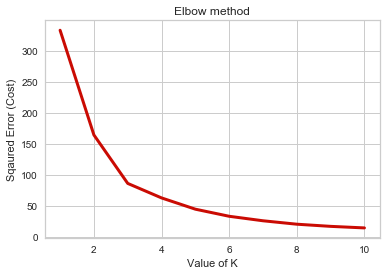

In [375]:
#Finding optimal K using elbow method
cost = []

for k in range(1,11):
    k_means = KMeans(n_clusters = k, max_iter = 500) 
    k_means.fit(df_clustering_data) 

    cost.append(k_means.inertia_)

plt.title("Elbow method")
plt.plot(range(1, 11), cost, color ='r', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot 

################################################################################

                            Clustering

################################################################################

In [376]:
#Step 1
#Clustering using daily data
kmeans = KMeans(n_clusters= 5 ,random_state=0)
y_kmeans= kmeans.fit_predict(df_clustering_data)
df_training_set['clusters'] = y_kmeans

################################################################################

                            Visualizing the Clusters

################################################################################

In [377]:
#PCA
#Reduce the dimensionality
temp_list = [[], []]
pca = PCA(n_components=2)
components = pca.fit_transform(df_clustering_data)

for i in range(0, len(components)):
    temp_list[0].append(components[i][0])
    temp_list[1].append(components[i][1])
                                
df_training_set['component 1'] = temp_list[0]
df_training_set['component 2'] = temp_list[1]

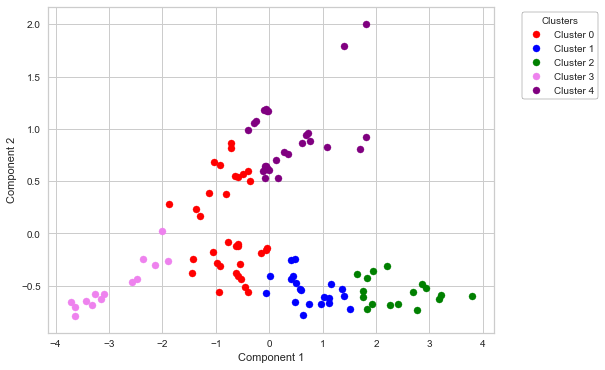

In [378]:
#Clustering plot
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(111)
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

labels = []

for cluster in set(y_kmeans):
    component1 = df_training_set.loc[df_training_set['clusters'] == cluster, 
                                     'component 1']
    component2 = df_training_set.loc[df_training_set['clusters'] == cluster, 
                                     'component 2']
    
    
    plt.scatter(component1,component2, c=colors2[cluster], s=50)
    
    labels.append("Cluster {}".format(cluster))
    ax1.legend(labels, loc='center left', bbox_to_anchor=(1.05, 0.85),title="Clusters", frameon=True, edgecolor='black')

plt.show()

################################################################################

                            Creating Multi-view model

################################################################################

In [388]:
#Step 2 and Step 3 - Performance and context features

#Dataframe to store all the features' values 
df_multi_view = pd.DataFrame(columns=['clusters', 
                                      'sec_supply_temp', 'sec_supply_temp_std', 
                                      'sec_return_temp', 'sec_return_temp_std',
                                      'prim_delta','prim_delta_std',
                                      'prim_heat_load', 'prim_heat_load_std',
                                     'vom', 'vos', 
                                      'efficiency', 'efficiency_std',
                                     'outdoor_temp', 'outdoor_temp_std', 
                                      'ratio_W_WD', 'ratio_C_A'])

#Operating view features
sec_supply_temp_feature = []
sec_supply_temp_feature_std = []

sec_return_temp_feature = []
sec_return_temp_feature_std = []

primary_delta_feature = []
primary_delta_feature_std = []

primary_heat_load_feature = []
primary_heat_load_feature_std = []

#Performance view features
vos_feature = []
vom_feature = []

efficiency_feature = []
efficiency_feature_std = []

#Conext view features
outdoor_temp = []
outdoor_temp_std = []

ratio_W_WD = []
ratio_C_P = []

weekend= []
work_day = []

#Number of clusters
clusters = list(set(y_kmeans))

#Calculating average value of each feature for each cluster
for cluster in clusters:
    df_temp = df_training_set.loc[df_training_set['clusters'] == cluster]

    #calculating average of each feature(F1, F2, F3) for each cluster(0,1,2,...) 
    #(Control valve system behavior modes - operating behavior mode - operating view)
    sec_supply_temp_feature.append(round(df_temp['sec_supply_temp'].mean(), ndigits=2))
    sec_supply_temp_feature_std.append(round(df_temp['sec_supply_temp'].std(), ndigits=2))
    
    sec_return_temp_feature.append(round(df_temp['sec_return_temp'].mean(), ndigits=2))
    sec_return_temp_feature_std.append(round(df_temp['sec_return_temp'].std(), ndigits=2))
    
    primary_delta_feature.append(round(df_temp['prim_delta'].mean(), ndigits=2))
    primary_delta_feature_std.append(round(df_temp['prim_delta'].std(), ndigits=2))
    
    primary_heat_load_feature.append(round(df_temp['prim_heat_load'].mean(), ndigits=2))
    primary_heat_load_feature_std.append(round(df_temp['prim_heat_load'].std(), ndigits=2))

    #Calculating average of VOM, VOS, and efficiency for each cluster (Performance view - performance mode)
    vos_feature.append(round(df_temp['vos'].mean(), ndigits=2))
    vom_feature.append(round(df_temp['vom'].mean(), ndigits=2))
    
    efficiency_feature.append(round(df_temp['efficiency'].mean(), ndigits=2))
    efficiency_feature_std.append(round(df_temp['efficiency'].std(), ndigits=2))

    #Calculating average of outdoor temp and ratio w/wd for each cluster (context view - context mode)
    outdoor_temp.append(round(df_temp['d_avg_outdoor_temp'].mean(), ndigits=2))
    outdoor_temp_std.append(round(df_temp['d_avg_outdoor_temp'].std(), ndigits=2))

    weekend.append(len(df_temp.loc[(df_temp.index.day_name() == 'Saturday') | (df_temp.index.day_name() == 'Sunday')]))
    work_day.append(len(df_temp.loc[(df_temp.index.day_name() != 'Saturday') | (df_temp.index.day_name() != 'Sunday')]))
    ratio_W_WD.append(round(weekend[cluster] / work_day[cluster], ndigits=3))

    #Calculating ratio cluster size/population (ratio_C_A)
    ratio_C_P.append(round(len(df_temp) / len(df_training_set), ndigits=10))
    

    #Create a dataframe out of all the values in the previous step. This is equal to step 1 of the method.
    df_multi_view = df_multi_view.append({'clusters': clusters[cluster], 'sec_supply_temp': sec_supply_temp_feature[cluster],
                            'sec_supply_temp_std': sec_supply_temp_feature_std[cluster],
                            'sec_return_temp': sec_return_temp_feature[cluster], 
                            'sec_return_temp_std': sec_return_temp_feature_std[cluster],
                            'prim_delta':primary_delta_feature[cluster],'prim_delta_std':primary_delta_feature_std[cluster],
                            'prim_heat_load':primary_heat_load_feature[cluster],'prim_heat_load_std':primary_heat_load_feature_std[cluster],
                            'vom': vom_feature[cluster], 'vos': vos_feature[cluster], 
                            'efficiency':efficiency_feature[cluster], 'efficiency_std':efficiency_feature_std[cluster],
                            'outdoor_temp':outdoor_temp[cluster],'outdoor_temp_std':outdoor_temp_std[cluster],
                            'ratio_W_WD':ratio_W_WD[cluster], 
                            'ratio_C_A':ratio_C_P[cluster]}, ignore_index=True)

#Seting cluster id's as index
df_multi_view['clusters'] = df_multi_view['clusters'].astype('int32')
df_multi_view.set_index('clusters', inplace=True)
df_multi_view_display = df_multi_view[['sec_supply_temp', 'sec_return_temp', 'prim_heat_load', 'vom', 'vos', 'efficiency','outdoor_temp','ratio_W_WD', 'ratio_C_A']]

# df_org.rename(columns={'A': 'a'}, index={'ONE': 'one'}, inplace=True)
df_multi_view_display.rename(columns={'sec_supply_temp':'SST', 
                                      'sec_return_temp':'SRT',
                                      'prim_heat_load':'PHL',
                                      'outdoor_temp':'OT',
                                      'ratio_W_WD':'RWB',
                                      'ratio_C_A':'RCA',
                                     'vom':'VOM',
                                     'vos':'VOS',
                                     'efficiency':'SE'}, 
                                    index={'clusters':'TOM'},
                                    inplace=True)
df_multi_view_display[['SST', 'SRT', 'PHL', 'OT', 'RWB', 'RCA', 'VOM', 'VOS', 'SE']]

,SST,SRT,PHL,VOM,VOS,SE,OT,RWB,RCA
clusters,,,,,,,,,
0,42.64,36.81,23.55,14.16,0.51,0.95,5.67,0.303,0.294643
1,46.88,37.92,39.76,17.94,0.49,0.96,1.51,0.400,0.178571
2,51.94,40.18,51.36,18.96,0.64,0.97,-2.96,0.176,0.151786
3,36.21,32.86,13.68,11.97,0.50,0.89,10.25,0.214,0.125000
4,46.00,39.84,23.41,13.67,0.50,0.96,2.64,0.321,0.250000


################################################################################

                Calculating Furthest Datapoint in Each Cluster

################################################################################

In [380]:
#Find the max distance from the centroid in each cluster:
#1. get the data points 
#2. calculate the distance
#3. Find the maximum distance
#4. Add to the multiview_model
df_temp = pd.DataFrame()
max_dist = []

for cluster in clusters:
    
    
    dist = []
    df_temp = df_training_set.loc[df_training_set['clusters'] == cluster]
    cluster_centroid = df_multi_view.loc[df_multi_view.index == cluster , ['sec_supply_temp', 'sec_return_temp', 'prim_heat_load']]
    
    for index, row in df_temp.iterrows():
        datapoint = row[['sec_supply_temp', 'sec_return_temp', 'prim_heat_load']]
        
        dist.append(distance.euclidean(datapoint, cluster_centroid))
        
    max_dist.append(round(max(dist), ndigits=3))
    
df_multi_view['max_dist'] = max_dist

################################################################################

                        Zoomed-views of the Measurements

################################################################################

In [381]:
#Step 2 and 3 - 24-hour VOM, efficiency,and outdoor temperature

#Creating multi-view dataframe index
df_zoomed_view_labels = []
for i in range(0,24):
    df_zoomed_view_labels.append('{}:00'.format(i))

#It is used to store the zoomed view label tables for all the clusters. The number of clusters may varies. So this way doesn't matter how many clusters we have.
multi_view_zoomed_labels_list = []

#Creating zoomed view labels (VOM, efficiency, outdoor_temp)
for cluster in clusters:
    
    #Storing zoomed view labels in a dataframe
    df_multi_view_zoomed_labels = pd.DataFrame(index=df_zoomed_view_labels, columns=['vom', 'efficiency', 
                    'outdoor_temp', 'prim_delta', 'prim_heat_load','prim_supply_temp', 'sec_return_temp'])
    
    #Zoomed view labels
    VOM_zoomed_view = []
    
    efficiency_zoomed_view = []
    
    outdoor_temp_zoomed_view = []
    
    primary_delta_zoomed_view = []
    primary_heat_load_zoomed_view = []
    
    primary_supply_temp_zoomed_view = []
    primary_return_temp_zoomed_view = []
    
    secondary_supply_temp_zoomed_view = []
    secondary_return_temp_zoomed_view = []
    
    #Creating temperoray dataframes
    df_temp = pd.DataFrame()
    
    #Getting the dates of data points in each cluster. These dates will be used to find the hourly data of the datapoints to create zoomed views.
    df_temp_dates = df_training_set.loc[df_training_set['clusters'] == cluster].index
    
    
    #finding and storing hourly data of each cluster
    for date in df_temp_dates:
        
        #Matching the dates of the datapoints in each cluster with hourly data.
        df_temp = df_temp.append(df_heating_seasons_hourly_data.loc[df_heating_seasons_hourly_data.index.date == date])
        
    #Making 24-hour zoomed view profiles
    for hour in set(df_temp.index.hour):
        
        #Calculating and storing 24-hour zoomed view values 
        VOM_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'vom'].mean(), ndigits=3))
        
        efficiency_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'efficiency'].mean(), ndigits=3))
        
        outdoor_temp_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'h_avg_outdoor_temp'].mean(), ndigits=3))
        
        primary_delta_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'prim_delta'].mean(), ndigits=3))
        primary_heat_load_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'prim_heat_load'].mean(), ndigits=3))
        
        primary_supply_temp_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'prim_supply_temp'].mean(), ndigits=3))
        primary_return_temp_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'prim_return_temp'].mean(), ndigits=3))
        
        secondary_supply_temp_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'sec_supply_temp'].mean(), ndigits=3))
        secondary_return_temp_zoomed_view.append(round(df_temp.loc[df_temp.index.hour == hour, 'sec_return_temp'].mean(), ndigits=3))
        
    #Creating a dataframe that stores all the zoomed view labels
    df_multi_view_zoomed_labels['vom'] = VOM_zoomed_view
    
    df_multi_view_zoomed_labels['efficiency'] = efficiency_zoomed_view
    
    df_multi_view_zoomed_labels['outdoor_temp'] = outdoor_temp_zoomed_view
    
    df_multi_view_zoomed_labels['prim_delta'] = primary_delta_zoomed_view
    df_multi_view_zoomed_labels['prim_heat_load'] = primary_heat_load_zoomed_view
    
    df_multi_view_zoomed_labels['prim_supply_temp'] = primary_supply_temp_zoomed_view
    df_multi_view_zoomed_labels['prim_return_temp'] = primary_return_temp_zoomed_view
    
    df_multi_view_zoomed_labels['sec_supply_temp'] = secondary_supply_temp_zoomed_view
    df_multi_view_zoomed_labels['sec_return_temp'] = secondary_return_temp_zoomed_view
    
    
    multi_view_zoomed_labels_list.append(df_multi_view_zoomed_labels)

################################################################################

                        Visualizing the Zoomed-views

################################################################################

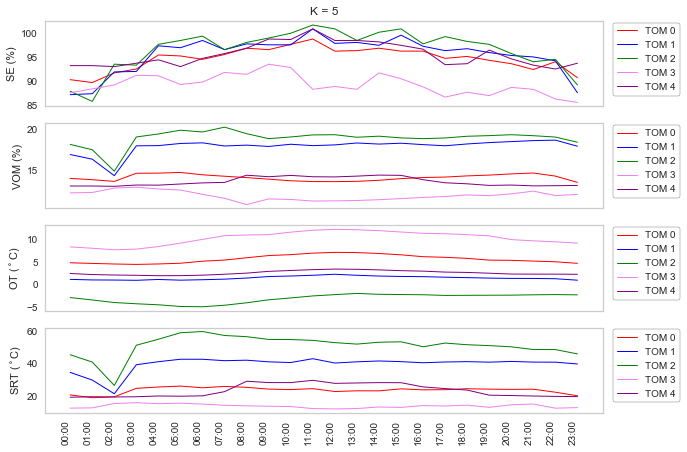

In [382]:
#Creating time series plots for the zoomed views (labels) of the clusters
xticks = [x for x in range(0,24)]
xtickslabels = ['00:00', '01:00', '02:00', '03:00', 
          '04:00', '05:00', '06:00', '07:00', 
          '08:00', '09:00', '10:00', '11:00', 
          '12:00', '13:00', '14:00', '15:00',
          '16:00', '17:00', '18:00', '19:00',
          '20:00', '21:00', '22:00', '23:00']

#Adding 3 plots for each cluster (VOM, efficiency, and outdoor temperature)
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4,1, figsize=(10,8), sharex=True)

ax1.set_xticks(xticks)
ax1.set_xticklabels(xtickslabels)
ax1.set_title("K = {}".format(len(clusters)))
ax1.set_ylabel("SE (%)")

ax2.set_xticks(xticks)
ax2.set_xticklabels(xtickslabels)
ax2.set_ylabel("VOM (%)")

ax3.set_xticks(xticks)
ax3.set_xticklabels(xtickslabels)
ax3.set_xlabel("Time")
ax3.set_ylabel("OT ($^\circ$C)")

ax4.set_xticks(xticks)
ax4.set_xticklabels(xtickslabels)
ax4.set_ylabel("PHL (kW)")

ax4.set_xticks(xticks)
ax4.set_xticklabels(xtickslabels)
ax4.set_ylabel("SRT ($^\circ$C)")

#Creating x-axis (24-hours)
time_series = [x for x in range(0,24)]
        
ax1.set_prop_cycle(color=colors2)
ax2.set_prop_cycle(color=colors2)
ax3.set_prop_cycle(color=colors2)
ax4.set_prop_cycle(color=colors2)





for cluster in clusters:
    
    
    
    #getting the values of the zoomed views (labels) for each cluster and plot them
    efficiency = multi_view_zoomed_labels_list[cluster]['efficiency'] * 100
    vom = multi_view_zoomed_labels_list[cluster]['vom']
    outdoor_temp = multi_view_zoomed_labels_list[cluster]['outdoor_temp']
    PHL = multi_view_zoomed_labels_list[cluster]['prim_heat_load']
    SST = multi_view_zoomed_labels_list[cluster]['sec_supply_temp']
    SRT = multi_view_zoomed_labels_list[cluster]['sec_return_temp']
    
    #Efficiency
    ax1.grid(False)
    ax1.plot(time_series,efficiency, lw=1, label="TOM {}".format(cluster))
    ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.55), frameon=True, edgecolor='black')
     
    
    #vom
    ax2.plot(time_series, vom, lw=1, label="TOM {}".format(cluster))
    ax2.grid(False)
    ax2.legend(loc='center left', bbox_to_anchor=(1.01, 0.55), frameon=True, edgecolor='black')
    
    
    #outdoor temp
    ax3.plot(time_series, outdoor_temp, lw=1, label="TOM {}".format(cluster))
    ax3.grid(False)
    ax3.legend(loc='center left', bbox_to_anchor=(1.01, 0.55), frameon=True, edgecolor='black')
    
    #PHL
    ax4.plot(time_series, PHL, lw=1, label="TOM {}".format(cluster))
    ax4.grid(False)
    ax4.legend(loc='center left', bbox_to_anchor=(1.01, 0.55), frameon=True, edgecolor='black')
    
    
    
    fig.autofmt_xdate(rotation=90)
    
# plt.savefig(figures_time_series_path + 'zoomed views (labels) time-series - K = {} - VS01.png'.format(len(clusters), cluster))
# plt.savefig(figures_time_series_path + "SRT-SE-VOM-OT.pdf".format(len(set(y_kmeans))), format="pdf", dpi=300, bbox_inches="tight")
    

In [383]:
#Adding extra features:
#1. The months that are involved or number of days for each month,
#2. The average outdoor temperature for that month or for the days involved.
#3. Compute the standard deviation of the outdoor temperature for the whole cluster (or for every months or days) 
#The last one giveu us an impression of the outdoor temperature differences during day and night on average for days included in the cluster.

#A list to store the dataframes for each cluster
clusters_info = []
# weekly_data = df_data.resample('W').mean()
# weekly_data.rename(columns={'h_avg_outdoor_temp':'w_avg_outdoor_temp'}, inplace=True)

#iterate clusters
for cluster in clusters:
    
    #This dataframe will hold the info's like month, days, daily outdoor temperature, and standard deviation of the outdoor temperature in each cluster.
    df_cluster_details = pd.DataFrame()
    
    #Definning temp dataframes and lists
    df_temp_dates = pd.DataFrame()
    df_temp = pd.DataFrame()
    df_temp2 = pd.DataFrame()
    df_temp3 = pd.DataFrame()
    temp_list = []
    
    #Getting the data for each clsuter
    df_temp = df_training_set.loc[df_training_set['clusters'] == cluster]
    df_temp['week'] = df_training_set.loc[df_training_set['clusters'] == cluster].index.week
    
    #Extracting the info required
    df_cluster_details['month'] = df_temp.index.month_name()
    df_cluster_details['week'] = df_temp.index.week
    df_cluster_details['day'] = df_temp.index.day
    df_cluster_details['d_avg_outdoor_temp'] = np.around(df_temp['d_avg_outdoor_temp'].values, decimals=2)
        
    
    df_cluster_details['sec_supply_temp'] = np.around(df_temp['sec_supply_temp'].values, decimals=2)
    df_cluster_details['sec_return_temp'] = np.around(df_temp['sec_return_temp'].values, decimals=2)
    df_cluster_details['prim_heat_load'] = np.around(df_temp['prim_heat_load'].values, decimals=2)
    df_cluster_details['vom'] = np.around(df_temp['vom'].values, decimals=2)
    df_cluster_details['vos'] = np.around(df_temp['vos'].values, decimals=2)
    df_cluster_details['day_name'] = df_temp.index.day_name()
    
    #Getting the dates of the datapoints in each cluster
    df_temp_dates = df_training_set.loc[df_training_set['clusters'] == cluster].index
    
    #finding and storing hourly data of each cluster
    for date in df_temp_dates:
        
        #Matching the dates of the datapoints in each cluster with hourly data.
        df_temp2 = df_heating_seasons_hourly_data.loc[df_heating_seasons_hourly_data.index.date == date]
        
        #Calculating outdoor std for each day in each cluster
        temp_list.append(round(df_temp2['h_avg_outdoor_temp'].std(), ndigits=2))
    
    
    #Storing outdoor std in the dataframe
    df_cluster_details['d_outdoor_temp_std'] = temp_list
    
    #Storing the dataframes in a list (cluster_datapoints_data)
    clusters_info.append(df_cluster_details)

################################################################################

                  Months and Days Distribution in Each Cluster

################################################################################

In [384]:
#Get the month names and the number of their names in each cluster
clusters_months = []

for cluster in clusters:
    
    cluster_month = []
    temp_list = []
    temp_list2 = []
    temp_list3 = []
    
    df_temp = pd.DataFrame(columns=['Month', 'Number of days', 'OT'])
    cluster_month_sorted = []
    
    #Create a dataframe that shows the month in each cluster and the number of days in each month in the cluster
    cluster_month_not_sorted = list(set(clusters_info[cluster]['month']))
    
    #sort the months in the list
    for month in all_month:
        if month in cluster_month_not_sorted:
            cluster_month_sorted.append(cluster_month_not_sorted[cluster_month_not_sorted.index(month)])
    
    for month in cluster_month_sorted:
        
        temp_list.append(month)
        temp_list2.append(len(clusters_info[cluster].loc[clusters_info[cluster]['month'] == month]))
        temp_list3.append(round(clusters_info[cluster].loc[clusters_info[cluster]['month'] == month, 'd_outdoor_temp_std'].mean(), ndigits=3))
        
    for i in range(0, len(temp_list)):
        df_temp = df_temp.append({'Month': temp_list[i], 'Number of days':temp_list2[i], 'OT':temp_list3[i]},ignore_index=True)
    
    clusters_months.append(df_temp)
    print("TOM {}:\n".format(cluster))
    print(clusters_months[cluster])
    print("\n")

TOM 0:

      Month Number of days     OT
0  February             10  1.436
1     March              3  1.830
2       May              2  1.975
3   October              5  1.636
4  November              8  1.010
5  December              5  0.828


TOM 1:

      Month Number of days     OT
0   January             11  0.960
1  February              6  1.018
2     March              3  1.427


TOM 2:

      Month Number of days     OT
0   January             11  1.525
1  February              4  3.672
2     March              2  1.905


TOM 3:

      Month Number of days     OT
0     April              1  5.140
1       May              2  3.045
2   October             10  1.348
3  November              1  0.590


TOM 4:

      Month Number of days     OT
0   October              2  1.145
1  November             12  1.114
2  December             14  0.966




################################################################################

      Calculating Average Standard Deviation of the Outdoor Temperature

################################################################################

In [385]:
#showing average std of the outdoor temperature
cluster_avg_outdoor_temp_std = pd.DataFrame(columns=['TOM', 'OT standard deviation ($^\circ$C)'])
temp_list = []

for cluster in clusters:
    temp_list.append(round(clusters_info[cluster]['d_outdoor_temp_std'].mean(), ndigits=3))
    cluster_avg_outdoor_temp_std = cluster_avg_outdoor_temp_std.append({'TOM':cluster, 'OT standard deviation ($^\circ$C)':temp_list[cluster]}, ignore_index=True)

cluster_avg_outdoor_temp_std['TOM'] = cluster_avg_outdoor_temp_std['TOM'].astype('int32')
cluster_avg_outdoor_temp_std.set_index('TOM', inplace=True)
cluster_avg_outdoor_temp_std

,OT standard deviation ($^\circ$C)
TOM,
0,1.339
1,1.047
2,2.075
3,1.807
4,1.042


################################################################################

                        Detecting Deviating Behaviours

################################################################################

In [386]:
#Finding dates with deviating behaviors
#The results will be stores in a logfile
df_testing_set_updated, results = deviating_behavior_detector(df_testing_set, df_multi_view)
results

,date,day,avg. outdoor temp,type of outlier,reason,action
0,2019-01-02,Wednesday,-0.367,typical,TOM2,-
1,2019-01-04,Friday,3.359,typical,TOM1,-
2,2019-01-12,Saturday,1.200,typical,TOM1,-
3,2019-01-14,Monday,-1.753,typical,TOM2,-
4,2019-01-18,Friday,-4.223,typical,TOM2,-
5,2019-01-19,Saturday,-2.228,deviating,SE,Analyze and Diagnose
6,2019-01-23,Wednesday,0.039,typical,TOM1,-
7,2019-01-26,Saturday,-3.007,deviating,SE,Analyze and Diagnose
8,2019-01-29,Tuesday,1.278,typical,TOM1,-
9,2019-02-05,Tuesday,1.261,typical,TOM1,-
